In [1]:
import os
os.chdir("..")
assert 'PromptDataExtract' in os.getcwd()

In [2]:
# Load settings
from backend import sett, postgres
from backend.utils.frame import Frame
sett.load_settings()
postgres.load_settings()

Load OK: settings.yaml


In [3]:
# Connect to database
db = postgres.connect('polylet')

      -- postgres_ SSH tunnel established.
NOTE  -- postgres_ Connected to PostGres DB: polylet (took 0.042 s)


In [77]:
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    plt.style.use("PromptDataExtraction/notebooks/matplotlib.mplstyle")
except:
    try:
        plt.style.use("~/matplotlib.mplstyle")
    except: pass


In [5]:
def execute(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    if not results:
        return None
    return pd.DataFrame.from_records(results, columns=results[0]._fields)

In [6]:
def timings(seconds : int):
    # Total time on the pipeline.
    print(str(datetime.timedelta(seconds = seconds)))
    print(f"{seconds / 3600 :.2f} hours")

In [7]:
# List of extraction methods.
execute("""select * from extraction_methods order by dataset Limit 10""")

,name,dataset,model,api,para_subset,extraction_info,id,date_added
0,tg-gpt35-sel1k,data1,gpt-3.5-turbo,openai,tg-ner-sel1k-no-unit,"{'user': 'sonakshi', 'shot_selector': 'random'...",121,2023-10-09 14:29:13.016268-04:00
1,sd-gpt35-sel1k,data1,gpt-3.5-turbo,openai,sd-ner-sel1k-no-unit,"{'user': 'sonakshi', 'shot_selector': 'random'...",126,2023-10-09 14:29:13.341392-04:00
2,loi-gpt35-sel1k,data1,gpt-3.5-turbo,openai,loi-ner-sel1k-no-unit,"{'user': 'sonakshi', 'shot_selector': 'random'...",120,2023-10-09 14:29:13.008154-04:00
3,lcst-gpt35-sel1k,data1,gpt-3.5-turbo,openai,lcst-ner-sel1k-no-unit,"{'user': 'sonakshi', 'shot_selector': 'random'...",108,2023-10-09 14:27:59.338182-04:00
4,td-gpt35-sel1k,data1,gpt-3.5-turbo,openai,td-ner-sel1k-no-unit,"{'user': 'sonakshi', 'shot_selector': 'random'...",115,2023-10-09 14:29:12.746045-04:00
5,ct-gpt35-sel1k,data1,gpt-3.5-turbo,openai,ct-ner-sel1k-no-unit,"{'user': 'sonakshi', 'shot_selector': 'random'...",103,2023-10-09 14:26:23.738124-04:00
6,ri-gpt35-sel1k,data1,gpt-3.5-turbo,openai,ri-ner-sel1k-no-unit,"{'user': 'sonakshi', 'shot_selector': 'random'...",116,2023-10-09 14:29:12.812407-04:00
7,ionic_cond-gpt35-sel1k,data1,gpt-3.5-turbo,openai,ionic_cond-ner-sel1k-no-unit,"{'user': 'sonakshi', 'shot_selector': 'random'...",112,2023-10-09 14:27:59.417456-04:00
8,h2_perm-gpt35-sel1k,data1,gpt-3.5-turbo,openai,h2_perm-ner-sel1k-no-unit,"{'user': 'sonakshi', 'shot_selector': 'random'...",110,2023-10-09 14:27:59.399824-04:00
9,tm-gpt35-sel1k,data1,gpt-3.5-turbo,openai,tm-ner-sel1k-no-unit,"{'user': 'sonakshi', 'shot_selector': 'random'...",118,2023-10-09 14:29:12.889908-04:00


In [8]:
# Number of selected papers.
execute("""
    SELECT count(*) FROM filtered_papers fp 
    WHERE fp.filter_name = 'select-1k';
""")

,count
0,1000


In [9]:
# Number of the selected papers from the curated dataset.
execute("""
SELECT count(*) FROM filtered_papers fp 
WHERE fp.filter_name = 'select-1k'
AND EXISTS (
	SELECT 1 FROM curated_data cd 
	WHERE cd.doi = fp.doi
);""")

,count
0,630


In [10]:
# Number of paragraphs from the select 1k.
execute("""
    SELECT count(*) FROM paper_texts pt 
    JOIN filtered_papers fp ON fp.doi = pt.doi 
    WHERE fp.filter_name = 'select-1k';
""")

,count
0,37434


In [11]:
propcount = Frame()

def execute_count(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    if not results:
        return None
    count = results[0][0]
    return count


# Methods IDs for property specific bert pipelines.
id_name = {
    38: 'glass transition temperature',
    39: 'melting temperature',
    40: 'thermal decomposition temperature',
    41: 'thermal conductivity',
    42: 'tensile strength',
    43: 'youngs modulus',
    44: 'compressive strength', 
    45: 'elongation at break',
    46: 'flexural strength',
    47: 'impact strength',
    48: 'ion exchange capacity',
    49: 'ionic conductivity',
    50: 'water contact angle',
    51: 'dielectric constant',
    52: 'density',
    53:  'bandgap',
    54: 'limiting oxygen index',
    55: 'hardness',
    56: 'lower critical solution temperature',
    57: 'upper critical solution temperature',
    58: 'CO_{2} permeability',
    59: 'O_{2} permeability',
    60: 'H_{2} permeability',
    61: 'crystallization temperature', 
    62: 'refractive index', 
    63: 'water uptake', 
    64: 'swelling degree', 
    65: 'methanol permeability'
}



# Methods IDs for property specific GPT pipelines.
gpt_id_name = {
    121: 'glass transition temperature',
    118: 'melting temperature',
    115: 'thermal decomposition temperature',
    124: 'thermal conductivity',
    117: 'tensile strength',
    114: 'youngs modulus',
    101: 'compressive strength', 
    104: 'elongation at break',
    111: 'flexural strength',
    106: 'impact strength',
    105: 'ion exchange capacity',
    112: 'ionic conductivity',
    119: 'water contact angle',
    102: 'dielectric constant',
    107: 'density',
    99:  'bandgap',
    120: 'limiting oxygen index',
    109: 'hardness',
    108: 'lower critical solution temperature',
    125: 'upper critical solution temperature',
    100: 'CO_{2} permeability',
    123: 'O_{2} permeability',
    110: 'H_{2} permeability',
    103: 'crystallization temperature', 
    116: 'refractive index', 
    122: 'water uptake', 
    126: 'swelling degree', 
    113: 'methanol permeability'
}

## Data6 - General NER - NER Pipeline.

In [12]:
method = postgres.raw_sql("""
    Select * From extraction_methods Where dataset = 'data6';
""")[0]
method

Row(name='g-ner-bert-sel1k', dataset='data6', model='materials-bert', api=None, para_subset='select-1k_ner-filter', extraction_info={'user': 'akhlak'}, id=5, date_added=datetime.datetime(2023, 9, 26, 8, 56, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000))))

In [13]:
# Number of paragraphs that passed the General NER filter.
execute("""
        SELECT count(*) FROM filtered_paragraphs fp 
        WHERE fp.filter_name = :method_para;
        
        """, method_para = method.para_subset)

,count
0,6215


In [14]:
# Number of materials extracted.
execute("""
        SELECT count(*) FROM extracted_materials em
        WHERE em.method_id = :mid;
        
        """, mid=method.id)

,count
0,9106


In [15]:
# Number of properties extracted.
execute("""
        SELECT count(*) FROM extracted_properties ep
        WHERE ep.method_id = :mid;
        
        """, mid=method.id)

,count
0,16368


In [16]:
# F1-score for Tg.
with open("runs/select-1k/bert/tg_metrics.json") as fp:
    print(json.load(fp))

{'method': 'g-ner-bert-sel1k', 'material': {'true_positives': 701, 'false_positives': 77, 'false_negatives': 146, 'precision': 0.9010282776349614, 'recall': 0.8276269185360094, 'F1': 0.8627692307692308}, 'value': {'true_positives': 548, 'false_positives': 230, 'false_negatives': 42, 'precision': 0.7043701799485861, 'recall': 0.9288135593220339, 'F1': 0.8011695906432748}, 'property': {'true_positives': 435, 'false_positives': 343, 'false_negatives': 158, 'precision': 0.5591259640102828, 'recall': 0.7335581787521079, 'F1': 0.6345733041575493}}


In [17]:
# F1-score for Bandgap.
with open("runs/select-1k/bert/eg_metrics.json") as fp:
    print(json.load(fp))

{'method': 'g-ner-bert-sel1k', 'material': {'true_positives': 332, 'false_positives': 21, 'false_negatives': 118, 'precision': 0.9405099150141643, 'recall': 0.7377777777777778, 'F1': 0.8268991282689913}, 'value': {'true_positives': 317, 'false_positives': 36, 'false_negatives': 23, 'precision': 0.8980169971671388, 'recall': 0.9323529411764706, 'F1': 0.9148629148629148}, 'property': {'true_positives': 233, 'false_positives': 120, 'false_negatives': 121, 'precision': 0.660056657223796, 'recall': 0.6581920903954802, 'F1': 0.659123055162659}}


In [18]:
# Time for filtering.
!grep "All done." runs/select-1k/filter/*.log

[23-09-26 EDT 08:57:06 AM] NOTE  -- All done. (took 2516.329 s)


In [19]:
# Time for extraction.
!grep "All done." runs/select-1k/bert/ner-filtered*.log

runs/select-1k/bert/ner-filtered.01.log:[23-09-27 EDT 02:59:47 PM] NOTE  -- All done. (took 42.097 s)
runs/select-1k/bert/ner-filtered.log:[23-09-27 EDT 03:43:35 PM] NOTE  -- All done. (took 2254.671 s)


In [20]:
# Time for scoring.
!grep "All done." runs/select-1k/bert/metrics.log

[23-09-30 EDT 08:21:22 AM] NOTE  -- All done. (took 21.939 s)


In [21]:
timings(2516 + 42 + 2254 + 21)

1:20:33
1.34 hours


In [22]:
count = 0

for _id, _name in id_name.items():
    result = execute_count("""
    SELECT count(ep.*)
    FROM extracted_properties ep
    WHERE ep.method_id = :id
    AND exists (
        SELECT 1
        FROM property_metadata pm
        WHERE pm.name = :name
        AND ep.entity_name = ANY(ARRAY[pm.other_names])
        );
    """, id = method.id, name = _name)
    print(_name, result)
    propcount.add(method=method.name, property=_name, count=result)
    count +=result

count

glass transition temperature 2193
melting temperature 263
thermal decomposition temperature 116
thermal conductivity 17
tensile strength 137
youngs modulus 16
compressive strength 11
elongation at break 67
flexural strength 19
impact strength 4
ion exchange capacity 28
ionic conductivity 49
water contact angle 55
dielectric constant 56
density 95
bandgap 1175
limiting oxygen index 11
hardness 9
lower critical solution temperature 8
upper critical solution temperature 0
CO_{2} permeability 11
O_{2} permeability 3
H_{2} permeability 0
crystallization temperature 16
refractive index 25
water uptake 8
swelling degree 0
methanol permeability 2


4394

## Data5 - General NER - LlaMa 2 Pipeline.

In [23]:
method = postgres.raw_sql("""
    Select * From extraction_methods Where name = 'g-ner-llama2-rand-sel1k';
""")[0]
method

Row(name='g-ner-llama2-rand-sel1k', dataset='data5', model='llama2-70B-chat', api='polyai', para_subset='select-1k_ner-filter', extraction_info={'user': 'akhlak', 'shot_selector': 'random', 'n_shots': 1, 'api_retry_delay': 60, 'delay_multiplier': 0.5, 'max_api_retries': 1, 'api_request_delay': 0.01, 'temperature': 0.001, 'prompt_id': 0, 'prompt': "Extract all numbers in JSONL format with 'material', 'property', 'value', 'condition' columns.", 'property': None, 'shot_nrecords': 2, 'shot_keywords': False}, id=10, date_added=datetime.datetime(2023, 9, 26, 8, 54, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000))))

In [24]:
# Number of materials extracted.
execute("""
        SELECT count(*) FROM extracted_materials em
        WHERE em.method_id = :mid;
        
        """, mid=method.id)

,count
0,12641


In [25]:
# Number of properties extracted.
execute("""
        SELECT count(*) FROM extracted_properties ep
        WHERE ep.method_id = :mid;
        
        """, mid=method.id)

,count
0,20825


In [26]:
# Number of tokens.
df = execute("""
             SELECT para_id, request_tokens, response_tokens, request_tokens + response_tokens AS total_tokens
             FROM  api_requests ar WHERE ar.method_id = :mid;
             
             """, mid=method.id)

df['api_cost'] = 0

print(f"Total tokens: {df['total_tokens'].sum():,}")
print(f"Total cost: $ {df['api_cost'].sum():.2f}")
print(f"Number of requests: {df.shape[0]:,}")
df

Total tokens: 7,084,245.0
Total cost: $ 0.00
Number of requests: 6,215


,para_id,request_tokens,response_tokens,total_tokens,api_cost
0,7861428,1198.0,98.0,1296.0,0
1,17590351,1156.0,164.0,1320.0,0
2,7865501,1171.0,178.0,1349.0,0
3,26610330,1024.0,113.0,1137.0,0
4,11278120,1212.0,234.0,1446.0,0
...,...,...,...,...,...
6210,26754210,711.0,46.0,757.0,0
6211,26754211,789.0,178.0,967.0,0
6212,26784396,1131.0,198.0,1329.0,0
6213,26784403,840.0,149.0,989.0,0


In [27]:
# Number of failed requests
execute("""
        SELECT count(*) FROM api_requests ar
        WHERE ar.method_id = :mid AND status != 'ok';

        """, mid=method.id)

,count
0,4


In [28]:
# Time for extraction.
!grep "All done." runs/select-1k/llama2-rand/llm-pipeline*.log

runs/select-1k/llama2-rand/llm-pipeline.01.log:[23-10-01 EDT 02:27:00 PM] NOTE  -- All done. (took 4893.190 s)
runs/select-1k/llama2-rand/llm-pipeline.02.log:[23-10-02 EDT 02:22:31 PM] NOTE  -- All done. (took 57520.373 s)
runs/select-1k/llama2-rand/llm-pipeline.03.log:[23-10-02 EDT 04:07:04 PM] NOTE  -- All done. (took 5321.607 s)
runs/select-1k/llama2-rand/llm-pipeline.04.log:[23-10-03 EDT 06:32:10 AM] NOTE  -- All done. (took 50573.198 s)
runs/select-1k/llama2-rand/llm-pipeline.log:[23-10-05 EDT 02:39:31 PM] NOTE  -- All done. (took 188452.338 s)


In [29]:
# Time for scoring.
!grep "All done." runs/select-1k/llama2-rand/metrics.log

[23-10-05 EDT 03:31:27 PM] NOTE  -- All done. (took 20.079 s)


In [30]:
timings(4893+57520+5321+50573+188452+20)

3 days, 13:12:59
85.22 hours


In [31]:
# F1-score for Tg.
with open("runs/select-1k/llama2-rand/tg_metrics.json") as fp:
    print(json.load(fp))

{'method': 'g-ner-llama2-rand-sel1k', 'material': {'true_positives': 508, 'false_positives': 225, 'false_negatives': 170, 'precision': 0.6930422919508867, 'recall': 0.7492625368731564, 'F1': 0.7200566973777461}, 'value': {'true_positives': 491, 'false_positives': 242, 'false_negatives': 118, 'precision': 0.669849931787176, 'recall': 0.80623973727422, 'F1': 0.7317436661698957}, 'property': {'true_positives': 385, 'false_positives': 348, 'false_negatives': 213, 'precision': 0.5252387448840382, 'recall': 0.6438127090301003, 'F1': 0.578512396694215}}


In [32]:
# F1-score for Eg.
with open("runs/select-1k/llama2-rand/eg_metrics.json") as fp:
    print(json.load(fp))

{'method': 'g-ner-llama2-rand-sel1k', 'material': {'true_positives': 300, 'false_positives': 70, 'false_negatives': 67, 'precision': 0.8108108108108109, 'recall': 0.8174386920980926, 'F1': 0.814111261872456}, 'value': {'true_positives': 317, 'false_positives': 53, 'false_negatives': 49, 'precision': 0.8567567567567568, 'recall': 0.8661202185792349, 'F1': 0.8614130434782608}, 'property': {'true_positives': 283, 'false_positives': 87, 'false_negatives': 75, 'precision': 0.7648648648648648, 'recall': 0.7905027932960894, 'F1': 0.7774725274725276}}


In [33]:
count = 0

for _id, _name in id_name.items():
    result = execute_count("""
    SELECT count(ep.*)
    FROM extracted_properties ep
    WHERE ep.method_id = :id
    AND exists (
        SELECT 1
        FROM property_metadata pm
        WHERE pm.name = :name
        AND ep.entity_name = ANY(ARRAY[pm.other_names])
        );
    """, id = method.id, name = _name)
    print(_name, result)
    propcount.add(method=method.name, property=_name, count=result)
    count +=result

count

glass transition temperature 3242
melting temperature 378
thermal decomposition temperature 254
thermal conductivity 28
tensile strength 180
youngs modulus 16
compressive strength 7
elongation at break 74
flexural strength 30
impact strength 5
ion exchange capacity 8
ionic conductivity 96
water contact angle 76
dielectric constant 58
density 86
bandgap 1554
limiting oxygen index 8
hardness 3
lower critical solution temperature 7
upper critical solution temperature 0
CO_{2} permeability 5
O_{2} permeability 1
H_{2} permeability 0
crystallization temperature 52
refractive index 26
water uptake 11
swelling degree 0
methanol permeability 4


6209

## Data4 - General NER - GPT 3.5 Pipeline.

In [34]:
method = postgres.raw_sql("""
    Select * From extraction_methods Where name = 'g-ner-gpt35-rand-sel1k';
""")[0]
method

Row(name='g-ner-gpt35-rand-sel1k', dataset='data4', model='gpt-3.5-turbo', api='openai', para_subset='select-1k_ner-filter', extraction_info={'user': 'akhlak', 'shot_selector': 'random', 'n_shots': 1, 'api_retry_delay': 5, 'delay_multiplier': 2.0, 'max_api_retries': 1, 'api_request_delay': 0.2, 'temperature': 0.001, 'prompt_id': 0, 'prompt': "Extract all numbers in JSONL format with 'material', 'property', 'value', 'condition' columns.", 'property': None, 'shot_nrecords': 2}, id=3, date_added=datetime.datetime(2023, 9, 26, 8, 53, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000))))

In [35]:
count = 0

for _id, _name in id_name.items():
    result = execute_count("""
    SELECT count(ep.*)
    FROM extracted_properties ep
    WHERE ep.method_id = :id
    AND exists (
        SELECT 1
        FROM property_metadata pm
        WHERE pm.name = :name
        AND ep.entity_name = ANY(ARRAY[pm.other_names])
        );
    """, id = method.id, name = _name)
    print(_name, result)
    propcount.add(method=method.name, property=_name, count=result)
    count +=result

count

glass transition temperature 2843
melting temperature 388
thermal decomposition temperature 241
thermal conductivity 30
tensile strength 214
youngs modulus 23
compressive strength 11
elongation at break 93
flexural strength 34
impact strength 11
ion exchange capacity 15
ionic conductivity 87
water contact angle 75
dielectric constant 64
density 123
bandgap 1275
limiting oxygen index 0
hardness 11
lower critical solution temperature 11
upper critical solution temperature 0
CO_{2} permeability 17
O_{2} permeability 6
H_{2} permeability 0
crystallization temperature 49
refractive index 24
water uptake 23
swelling degree 0
methanol permeability 4


5672

In [36]:
# Number of materials extracted.
execute("""
        SELECT count(*) FROM extracted_materials em
        WHERE em.method_id = :mid;
        
        """, mid=method.id)

,count
0,16191


In [37]:
# Number of properties extracted.
execute("""
        SELECT count(*) FROM extracted_properties ep
        WHERE ep.method_id = :mid;
        
        """, mid=method.id)

,count
0,29516


In [38]:
# Number of tokens.
df = execute("""
             SELECT para_id, request_tokens, response_tokens, request_tokens + response_tokens AS total_tokens
             FROM  api_requests ar WHERE ar.method_id = :mid;
             
             """, mid=method.id)

df['api_cost'] = (0.0015 * df['request_tokens'] + 0.002 * df['response_tokens']) / 1000

print(f"Total tokens: {df['total_tokens'].sum():,}")
print(f"Total cost: $ {df['api_cost'].sum():.2f}")
print(f"Number of requests: {df.shape[0]:,}")
df

Total tokens: 7,151,891
Total cost: $ 11.42
Number of requests: 6,215


,para_id,request_tokens,response_tokens,total_tokens,api_cost
0,13513075,923,80,1003,0.001545
1,5852577,1292,189,1481,0.002316
2,7865819,978,92,1070,0.001651
3,16932019,879,26,905,0.001370
4,13719192,779,41,820,0.001251
...,...,...,...,...,...
6210,26754210,623,97,720,0.001129
6211,26754211,1036,101,1137,0.001756
6212,26784396,802,295,1097,0.001793
6213,26784403,868,205,1073,0.001712


In [39]:
# Number of failed requests
execute("""
        SELECT count(*) FROM api_requests ar
        WHERE ar.method_id = :mid AND status != 'ok';

        """, mid=method.id)

,count
0,0


In [40]:
# F1-score for Tg.
with open("runs/select-1k/gpt35-rand/tg_metrics.json") as fp:
    print(json.load(fp))

{'method': 'g-ner-gpt35-rand-sel1k', 'material': {'true_positives': 546, 'false_positives': 211, 'false_negatives': 137, 'precision': 0.7212681638044914, 'recall': 0.7994143484626647, 'F1': 0.7583333333333334}, 'value': {'true_positives': 543, 'false_positives': 214, 'false_negatives': 69, 'precision': 0.7173051519154557, 'recall': 0.8872549019607843, 'F1': 0.7932797662527391}, 'property': {'true_positives': 441, 'false_positives': 316, 'false_negatives': 157, 'precision': 0.582562747688243, 'recall': 0.7374581939799331, 'F1': 0.6509225092250922}}


In [41]:
# F1-score for Bandgap.
with open("runs/select-1k/gpt35-rand/eg_metrics.json") as fp:
    print(json.load(fp))

{'method': 'g-ner-gpt35-rand-sel1k', 'material': {'true_positives': 302, 'false_positives': 45, 'false_negatives': 64, 'precision': 0.8703170028818443, 'recall': 0.825136612021858, 'F1': 0.847124824684432}, 'value': {'true_positives': 311, 'false_positives': 36, 'false_negatives': 47, 'precision': 0.8962536023054755, 'recall': 0.8687150837988827, 'F1': 0.8822695035460992}, 'property': {'true_positives': 285, 'false_positives': 62, 'false_negatives': 71, 'precision': 0.8213256484149856, 'recall': 0.800561797752809, 'F1': 0.8108108108108109}}


In [42]:
# Time for extraction.
!grep "All done." runs/select-1k/gpt35-rand/llm-pipeline*.log

runs/select-1k/gpt35-rand/llm-pipeline.01.log:[23-09-29 EDT 02:19:54 AM] NOTE  -- All done. (took 15204.971 s)
runs/select-1k/gpt35-rand/llm-pipeline.log:[23-09-30 EDT 01:44:11 AM] NOTE  -- All done. (took 59576.347 s)


In [43]:
# Time for scoring.
!grep "All done." runs/select-1k/gpt35-rand/metrics.log

[23-09-30 EDT 08:22:04 AM] NOTE  -- All done. (took 21.206 s)


In [44]:
timings(15204+59576+21)

20:46:41
20.78 hours


## Data4 - General NER - GPT 3.5 - Similar Pipeline.

In [45]:
method = postgres.raw_sql("""
    Select * From extraction_methods Where name = 'g-ner-gpt35-similar-sel1k';
""")[0]
method

Row(name='g-ner-gpt35-similar-sel1k', dataset='data4', model='gpt-3.5-turbo', api='openai', para_subset='select-1k_ner-filter', extraction_info={'user': 'akhlak', 'shot_selector': 'similar', 'n_shots': 1, 'api_retry_delay': 5, 'delay_multiplier': 2.0, 'max_api_retries': 1, 'api_request_delay': 0.2, 'temperature': 0.001, 'prompt_id': 0, 'prompt': "Extract all numbers in JSONL format with 'material', 'property', 'value', 'condition' columns.", 'property': None, 'shot_nrecords': 2, 'shot_keywords': False}, id=12, date_added=datetime.datetime(2023, 10, 4, 9, 48, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000))))

In [46]:
# Number of materials extracted.
execute("""
        SELECT count(*) FROM extracted_materials em
        WHERE em.method_id = :mid;
        
        """, mid=method.id)

,count
0,15800


In [47]:
# Number of properties extracted.
execute("""
        SELECT count(*) FROM extracted_properties ep
        WHERE ep.method_id = :mid;
        
        """, mid=method.id)

,count
0,29282


In [48]:
count = 0

for _id, _name in id_name.items():
    result = execute_count("""
    SELECT count(ep.*)
    FROM extracted_properties ep
    WHERE ep.method_id = :id
    AND exists (
        SELECT 1
        FROM property_metadata pm
        WHERE pm.name = :name
        AND ep.entity_name = ANY(ARRAY[pm.other_names])
        );
    """, id = method.id, name = _name)
    print(_name, result)
    propcount.add(method=method.name, property=_name, count=result)
    count +=result

count

glass transition temperature 2642
melting temperature 396
thermal decomposition temperature 259
thermal conductivity 31
tensile strength 202
youngs modulus 24
compressive strength 11
elongation at break 91
flexural strength 35
impact strength 11
ion exchange capacity 21
ionic conductivity 102
water contact angle 92
dielectric constant 71
density 116
bandgap 1407
limiting oxygen index 1
hardness 12
lower critical solution temperature 11
upper critical solution temperature 0
CO_{2} permeability 17
O_{2} permeability 7
H_{2} permeability 0
crystallization temperature 30
refractive index 27
water uptake 38
swelling degree 0
methanol permeability 4


5658

In [49]:
# Number of tokens.
df = execute("""
             SELECT para_id, request_tokens, response_tokens, request_tokens + response_tokens AS total_tokens
             FROM  api_requests ar WHERE ar.method_id = :mid;
             
             """, mid=method.id)

df['api_cost'] = (0.0015 * df['request_tokens'] + 0.002 * df['response_tokens']) / 1000

print(f"Total tokens: {df['total_tokens'].sum():,}")
print(f"Total cost: $ {df['api_cost'].sum():.2f}")
print(f"Number of requests: {df.shape[0]:,}")
df

Total tokens: 6,381,634
Total cost: $ 10.24
Number of requests: 6,215


,para_id,request_tokens,response_tokens,total_tokens,api_cost
0,11163019,750,100,850,0.001325
1,13068056,899,98,997,0.001545
2,15711490,801,79,880,0.001360
3,7864862,1238,246,1484,0.002349
4,7865824,906,138,1044,0.001635
...,...,...,...,...,...
6210,26754210,590,97,687,0.001079
6211,26754211,780,107,887,0.001384
6212,26784396,795,328,1123,0.001849
6213,26784403,638,196,834,0.001349


In [50]:
# Number of failed requests
execute("""
        SELECT count(*) FROM api_requests ar
        WHERE ar.method_id = :mid AND status != 'ok';

        """, mid=method.id)

,count
0,0


In [51]:
# F1-score for Tg.
with open("runs/select-1k/gpt35-similar/tg_metrics.json") as fp:
    print(json.load(fp))

{'method': 'g-ner-gpt35-similar-sel1k', 'material': {'true_positives': 547, 'false_positives': 189, 'false_negatives': 134, 'precision': 0.7432065217391305, 'recall': 0.8032305433186491, 'F1': 0.7720536344389556}, 'value': {'true_positives': 530, 'false_positives': 206, 'false_negatives': 76, 'precision': 0.720108695652174, 'recall': 0.8745874587458746, 'F1': 0.789865871833085}, 'property': {'true_positives': 446, 'false_positives': 290, 'false_negatives': 150, 'precision': 0.6059782608695652, 'recall': 0.7483221476510067, 'F1': 0.6696696696696697}}


In [52]:
# F1-score for Eg.
with open("runs/select-1k/gpt35-similar/eg_metrics.json") as fp:
    print(json.load(fp))

{'method': 'g-ner-gpt35-similar-sel1k', 'material': {'true_positives': 315, 'false_positives': 46, 'false_negatives': 53, 'precision': 0.8725761772853186, 'recall': 0.8559782608695652, 'F1': 0.8641975308641975}, 'value': {'true_positives': 323, 'false_positives': 38, 'false_negatives': 35, 'precision': 0.8947368421052632, 'recall': 0.9022346368715084, 'F1': 0.8984700973574409}, 'property': {'true_positives': 301, 'false_positives': 60, 'false_negatives': 55, 'precision': 0.8337950138504155, 'recall': 0.8455056179775281, 'F1': 0.8396094839609484}}


In [53]:
# Time for extraction.
!grep "All done." runs/select-1k/gpt35-similar/llm-pipeline*.log

runs/select-1k/gpt35-similar/llm-pipeline.01.log:[23-10-04 EDT 10:31:33 AM] NOTE  -- All done. (took 2440.726 s)
runs/select-1k/gpt35-similar/llm-pipeline.log:[23-10-05 EDT 07:15:52 PM] NOTE  -- All done. (took 112354.174 s)


In [54]:
# Time for scoring.
!grep "All done." runs/select-1k/gpt35-rand/metrics.log

[23-09-30 EDT 08:22:04 AM] NOTE  -- All done. (took 21.206 s)


In [55]:
timings(2440+112354+21)

1 day, 7:53:35
31.89 hours


## Data3 - Property-specific NER - BERT Pipeline.

In [56]:
method = postgres.raw_sql("""
    Select * From extraction_methods 
    Where dataset = 'data3' and name like '%-ner-bert-sel1k-no-unit';
""")
method

[Row(name='tg-ner-bert-sel1k-no-unit', dataset='data3', model='materials-bert', api=None, para_subset='tg-ner-sel1k-no-unit', extraction_info={'user': 'sonakshi'}, id=38, date_added=datetime.datetime(2023, 10, 7, 19, 26, 38, 753477, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000)))),
 Row(name='tm-ner-bert-sel1k-no-unit', dataset='data3', model='materials-bert', api=None, para_subset='tm-ner-sel1k-no-unit', extraction_info={'user': 'sonakshi'}, id=39, date_added=datetime.datetime(2023, 10, 7, 19, 29, 31, 289129, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000)))),
 Row(name='td-ner-bert-sel1k-no-unit', dataset='data3', model='materials-bert', api=None, para_subset='td-ner-sel1k-no-unit', extraction_info={'user': 'sonakshi'}, id=40, date_added=datetime.datetime(2023, 10, 7, 19, 30, 38, 860791, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000)))),
 Row(name='tc-ner-bert-sel1k-no-unit', dataset='data3', model='materials-bert', api=N

In [57]:
# db.rollback()

In [58]:
# Number of materials extracted.
execute("""
        SELECT count(*) FROM extracted_materials em
        WHERE em.method_id >= 38 and em.method_id <= 65 
        -- and em.method_id != 10;
        """)

,count
0,10383


In [59]:
# Number of properties extracted.
execute("""
        SELECT count(*) FROM extracted_properties ep
        WHERE ep.method_id >= 38 and ep.method_id <= 65;
        """)

,count
0,19857


In [60]:
# Deduplicated extracted materials

count = 0

for _id, _name in id_name.items():
    result = execute_count("""
    SELECT count(em.*)
    FROM extracted_properties ep
    JOIN extracted_materials em ON em.id = ep.material_id
    WHERE ep.method_id = :id
    AND exists (
        SELECT 1
        FROM property_metadata pm
        WHERE pm.name = :name
        AND ep.entity_name = ANY(ARRAY[pm.other_names])
        );
    """, id = _id, name = _name )
    print(_name, result)
    count +=result

count

glass transition temperature 2359
melting temperature 252
thermal decomposition temperature 131
thermal conductivity 17
tensile strength 141
youngs modulus 18
compressive strength 11
elongation at break 72
flexural strength 19
impact strength 4
ion exchange capacity 30
ionic conductivity 53
water contact angle 55
dielectric constant 64
density 101
bandgap 1260
limiting oxygen index 13
hardness 9
lower critical solution temperature 10
upper critical solution temperature 0
CO_{2} permeability 11
O_{2} permeability 3
H_{2} permeability 0
crystallization temperature 18
refractive index 27
water uptake 8
swelling degree 0
methanol permeability 2


4688

In [61]:
# Deduplicated extracted properties

count = 0

for _id, _name in id_name.items():
    result = execute_count("""
    SELECT count(ep.*)
    FROM extracted_properties ep
    JOIN extracted_materials em ON em.id = ep.material_id
    WHERE ep.method_id = :id
    AND exists (
        SELECT 1
        FROM property_metadata pm
        WHERE pm.name = :name
        AND ep.entity_name = ANY(ARRAY[pm.other_names])
        );
    """, id = _id, name = _name )
    print(_name, result)
    propcount.add(method="P-NER-BERT", property=_name, count=result)
    count +=result

count

glass transition temperature 2359
melting temperature 252
thermal decomposition temperature 131
thermal conductivity 17
tensile strength 141
youngs modulus 18
compressive strength 11
elongation at break 72
flexural strength 19
impact strength 4
ion exchange capacity 30
ionic conductivity 53
water contact angle 55
dielectric constant 64
density 101
bandgap 1260
limiting oxygen index 13
hardness 9
lower critical solution temperature 10
upper critical solution temperature 0
CO_{2} permeability 11
O_{2} permeability 3
H_{2} permeability 0
crystallization temperature 18
refractive index 27
water uptake 8
swelling degree 0
methanol permeability 2


4688

In [62]:
# Time for extraction.
!grep "All done." filtered_paras/sel1k/np2/*.log | awk -F '(took | s)' '{sum += $2} END {print sum}'

grep: filtered_paras/sel1k/np2/*.log: No such file or directory



In [63]:
timings(5875.01+517.561+923.808)

2:01:56.379000
2.03 hours


## Data1 - Property-specific NER - GPT Pipeline.

In [64]:
method = postgres.raw_sql("""
    Select * From extraction_methods 
    Where dataset = 'data1' and name like '%-gpt35-sel1k';
""")
method

[Row(name='h2_perm-gpt35-sel1k', dataset='data1', model='gpt-3.5-turbo', api='openai', para_subset='h2_perm-ner-sel1k-no-unit', extraction_info={'user': 'sonakshi', 'shot_selector': 'random', 'n_shots': 1, 'api_retry_delay': 60, 'delay_multiplier': 2.0, 'max_api_retries': 1, 'api_request_delay': 0.2, 'temperature': 0.001, 'prompt': "Extract all hydrogen or H2 permeability values in JSONL format with 'material', 'property', 'value', 'condition' columns.", 'shot_nrecords': 2, 'shot_keywords': 'false', 'property': None, 'prompt_id': 0}, id=110, date_added=datetime.datetime(2023, 10, 9, 14, 27, 59, 399824, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000)))),
 Row(name='lcst-gpt35-sel1k', dataset='data1', model='gpt-3.5-turbo', api='openai', para_subset='lcst-ner-sel1k-no-unit', extraction_info={'user': 'sonakshi', 'shot_selector': 'random', 'n_shots': 1, 'api_retry_delay': 60, 'delay_multiplier': 2.0, 'max_api_retries': 1, 'api_request_delay': 0.2, 'temperature': 0.001, 

In [65]:
# Number of materials extracted.
execute("""
      SELECT count(*) FROM extracted_materials em
      WHERE em.method_id >= 99 and em.method_id <= 126
      """)

,count
0,7188


In [66]:
# Number of properties extracted.
execute("""
        SELECT count(*) FROM extracted_properties ep
        WHERE ep.method_id >= 99 and ep.method_id <= 126
        --group by ep.method_id;
        """)

,count
0,9746


In [67]:
# Time for heuristic filtering.
!grep "All done." filtered_paras/sel1k/hf/*.log | awk -F '(took | s)' '{sum += $2} END {print sum}'

grep: filtered_paras/sel1k/hf/*.log: No such file or directory



In [68]:
# Time for ner filtering.
!grep "All Done." filtered_paras/sel1k/ner-no-unit/*.log | awk -F '(took | s)' '{sum += $2} END {print sum}'

grep: filtered_paras/sel1k/ner-no-unit/*.log: No such file or directory



In [69]:
# Time for extraction.
!grep "All done." filtered_paras/sel1k/gpt/*.log | awk -F '(took | s)' '{sum += $2} END {print sum}'

grep: filtered_paras/sel1k/gpt/*.log: No such file or directory



In [70]:
timings(5875.01+517.561+105150)

1 day, 6:59:02.571000
30.98 hours


In [71]:
# Deduplicated extracted materials
count = 0

for _id, _name in gpt_id_name.items():
    result = execute_count("""
    SELECT count(em.*)
    FROM extracted_properties ep
    JOIN extracted_materials em ON em.id = ep.material_id
    WHERE ep.method_id = :id
    AND exists (
        SELECT 1
        FROM property_metadata pm
        WHERE pm.name = :name
        AND ep.entity_name = ANY(ARRAY[pm.other_names])
        );
    """, id = _id, name = _name )
    print(_name, result)
    count +=result

count

glass transition temperature 1819
melting temperature 494
thermal decomposition temperature 560
thermal conductivity 20
tensile strength 228
youngs modulus 16
compressive strength 12
elongation at break 104
flexural strength 19
impact strength 4
ion exchange capacity 69
ionic conductivity 130
water contact angle 56
dielectric constant 71
density 149
bandgap 1152
limiting oxygen index 10
hardness 11
lower critical solution temperature 21
upper critical solution temperature 0
CO_{2} permeability 18
O_{2} permeability 9
H_{2} permeability 0
crystallization temperature 95
refractive index 49
water uptake 34
swelling degree 0
methanol permeability 1


5151

In [72]:
# Deduplicated extracted properties
count = 0

for _id, _name in gpt_id_name.items():
    result = execute_count("""
    SELECT count(ep.*)
    FROM extracted_properties ep
    JOIN extracted_materials em ON em.id = ep.material_id
    WHERE ep.method_id = :id
    AND exists (
        SELECT 1
        FROM property_metadata pm
        WHERE pm.name = :name
        AND ep.entity_name = ANY(ARRAY[pm.other_names])
        );
    """, id = _id, name = _name )
    print(_name, result)
    propcount.add(method="P-NER-GPT", property=_name, count=result)
    count +=result

count

glass transition temperature 1819
melting temperature 494
thermal decomposition temperature 560
thermal conductivity 20
tensile strength 228
youngs modulus 16
compressive strength 12
elongation at break 104
flexural strength 19
impact strength 4
ion exchange capacity 69
ionic conductivity 130
water contact angle 56
dielectric constant 71
density 149
bandgap 1152
limiting oxygen index 10
hardness 11
lower critical solution temperature 21
upper critical solution temperature 0
CO_{2} permeability 18
O_{2} permeability 9
H_{2} permeability 0
crystallization temperature 95
refractive index 49
water uptake 34
swelling degree 0
methanol permeability 1


5151

## Summary Plots

In [73]:
data = Frame()
data.add(name='P-NER-BERT', materials=4688, properties=4688, hours=2.03, cost=0.0, Tg=0.635, Eg=0.66)
data.add(name='P-NER-LLaMa', materials=0, properties=0, hours=0, cost=0.0, Tg=0.61, Eg=0.775)
data.add(name='P-NER-GPT / Random', materials=5151, properties=5151, hours=30.98, cost=8.52, Tg=0.67, Eg=0.87)
data.add(name='G-NER-BERT', materials=9106, properties=16368, hours=1.34, cost=0.0, Tg=0.65, Eg=0.65)
data.add(name='G-NER-LlaMa', materials=12641, properties=20825, hours=85.22, cost=0.0, Tg=0.58, Eg=0.77)
data.add(name='G-NER-GPT / Random', materials=16191, properties=29516, hours=20.78, cost=11.42, Tg=0.65, Eg=0.81)
data.add(name='G-NER-GPT / Similar', materials=15800, properties=29282, hours=31.89, cost=10.24, Tg=0.67, Eg=0.84)

metrics = data.df.set_index('name')
metrics

,materials,properties,hours,cost,Tg,Eg
name,,,,,,
P-NER-BERT,4688,4688,2.03,0.00,0.635,0.660
P-NER-LLaMa,0,0,0.00,0.00,0.610,0.775
P-NER-GPT / Random,5151,5151,30.98,8.52,0.670,0.870
G-NER-BERT,9106,16368,1.34,0.00,0.650,0.650
G-NER-LlaMa,12641,20825,85.22,0.00,0.580,0.770
G-NER-GPT / Random,16191,29516,20.78,11.42,0.650,0.810
G-NER-GPT / Similar,15800,29282,31.89,10.24,0.670,0.840


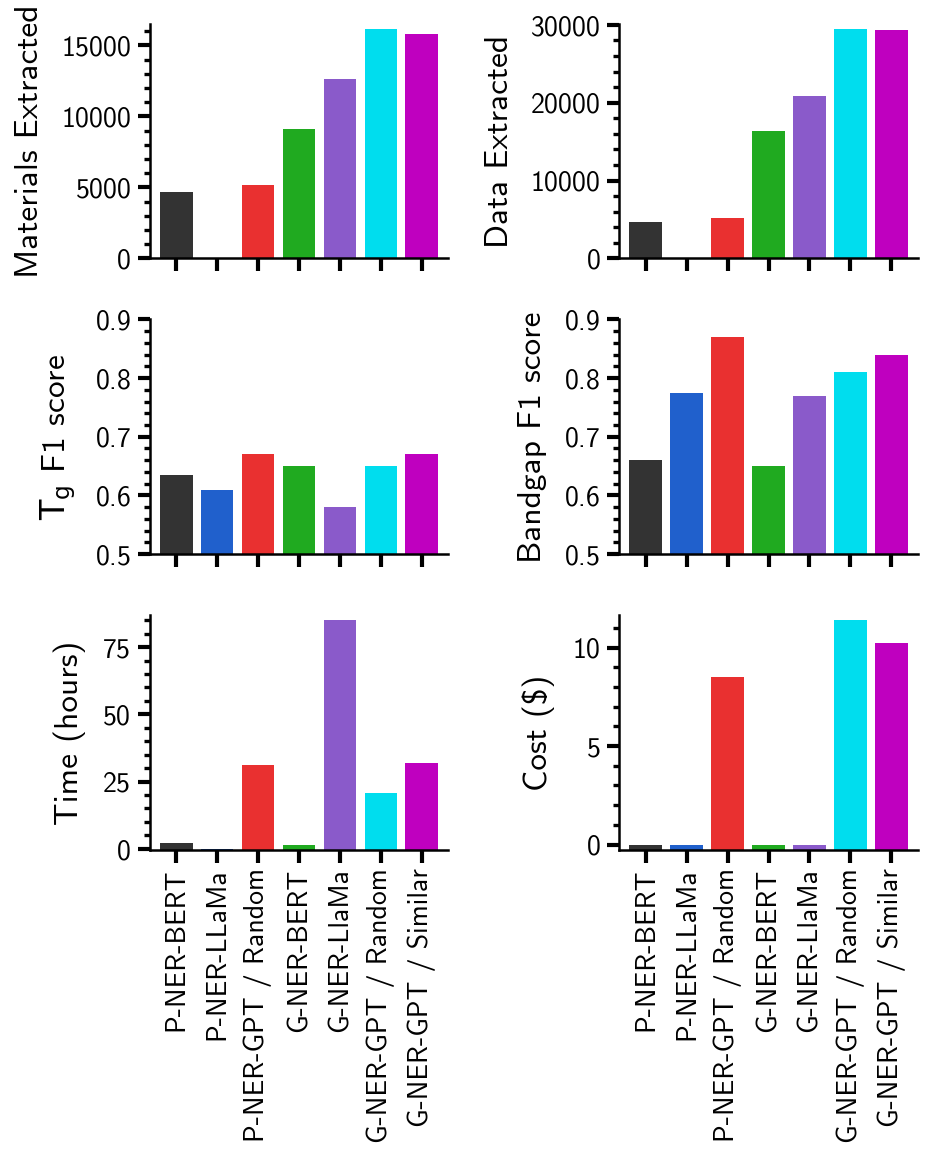

In [78]:
plt.rcParams['font.family'] = 'cursive'
colors = ["#333", "#2060cc", "#e93030", "#20aa20", "#8a5aca", "#00ddee", "m", "#e4a635"][:metrics.shape[0]]
voffset = -0.25

fig, axes = plt.subplots(3, 2, figsize=(3.25, 4), dpi=300, sharex=True)
axes = axes.flatten()

barprops = dict(color=colors, align='center', width=0.8, bottom=voffset)

ax = axes[0]
df = metrics['materials'] - voffset
df.plot.bar(ax=ax, **barprops)
ax.set(ylabel='Materials Extracted')

ax = axes[1]
df = metrics['properties'] - voffset
metrics['properties'].plot.bar(ax=ax, **barprops)
ax.set(ylabel='Data Extracted')

ax = axes[2]
df = metrics['Tg'] - voffset
df.plot.bar(ax=ax, **barprops)
ax.set(ylabel='$T_g$ F1 score', ylim=(0.5, 0.9))

ax = axes[3]
df = metrics['Eg'] - voffset
df.plot.bar(ax=ax, **barprops)
ax.set(ylabel='Bandgap F1 score', ylim=(0.5, 0.9))

ax = axes[4]
df = metrics['hours'] - voffset
df.plot.bar(ax=ax, **barprops)
ax.set(ylabel='Time (hours)')

ax = axes[5]

df = metrics['cost'] - voffset
df.plot.bar(ax=ax, **barprops)
ax.set(ylabel='Cost (\$)')

for ax in axes.flatten():
    ax.set(xlabel='')
    ax.tick_params(axis='x', which='minor', bottom=False)

plt.tight_layout()
plt.savefig("notebooks/Selec1k-Bars.eps")
plt.show()

In [79]:
# Extracted properties per pipeline.
propdf = propcount.df.pivot(columns='method', values='count', index='property')
propdf

method,P-NER-BERT,P-NER-GPT,g-ner-bert-sel1k,g-ner-gpt35-rand-sel1k,g-ner-gpt35-similar-sel1k,g-ner-llama2-rand-sel1k
property,,,,,,
CO_{2} permeability,11,18,11,17,17,5
H_{2} permeability,0,0,0,0,0,0
O_{2} permeability,3,9,3,6,7,1
bandgap,1260,1152,1175,1275,1407,1554
compressive strength,11,12,11,11,11,7
crystallization temperature,18,95,16,49,30,52
density,101,149,95,123,116,86
dielectric constant,64,71,56,64,71,58
elongation at break,72,104,67,93,91,74


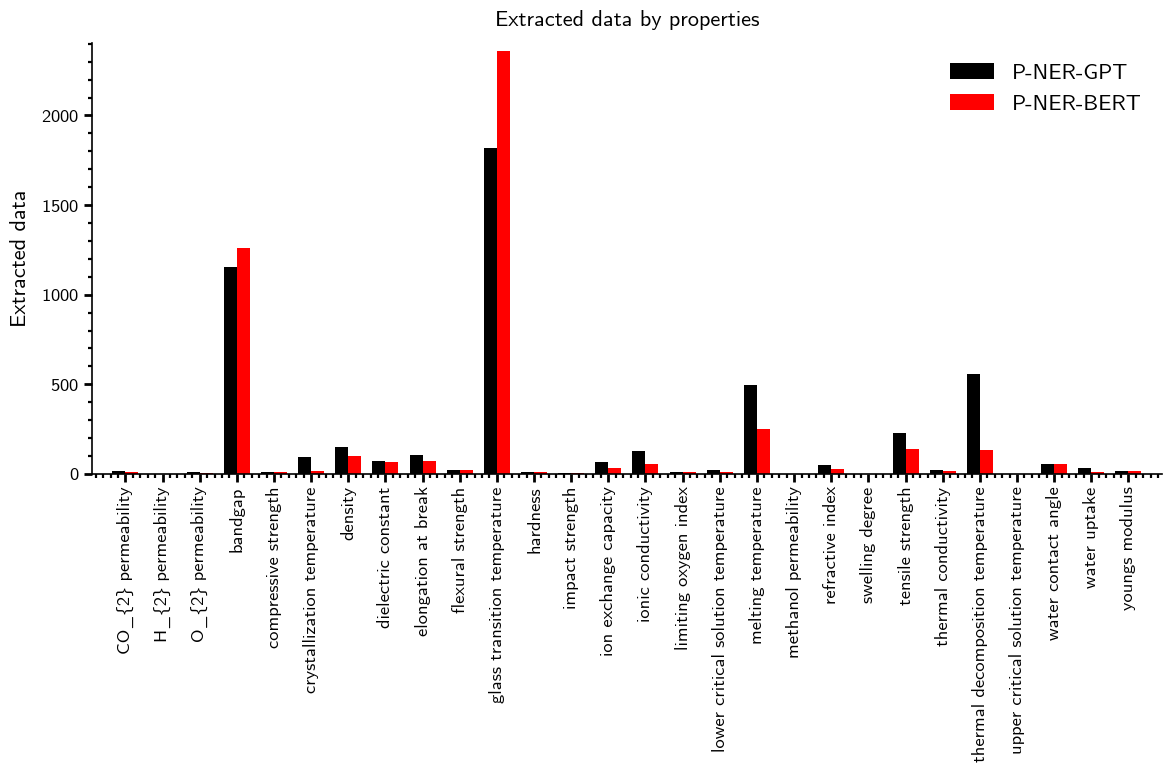

In [80]:
width = 0.35                            # the width of the bars

col1 = 'P-NER-GPT'
col2 = 'P-NER-BERT'

data1 = propdf[col1]
data2 = propdf[col2]

x = np.arange(propdf.shape[0])          # the label locations

fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
rects1 = ax.bar(x - width/2, data1, width, label=col1, color='k')
rects2 = ax.bar(x + width/2, data2, width, label=col2, color='r')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Extracted data')
ax.set_title('Extracted data by properties')
ax.set_xticks(x)
ax.set_xticklabels(propdf.index, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

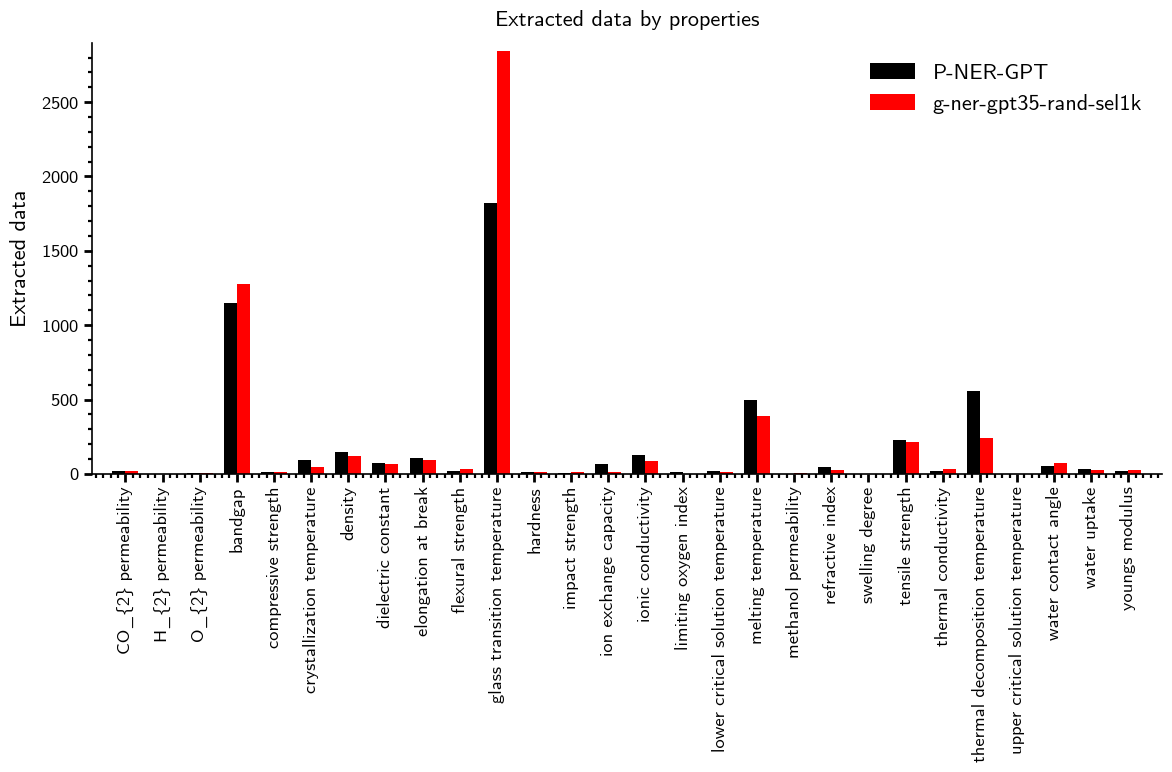

In [81]:
width = 0.35                            # the width of the bars

col1 = 'P-NER-GPT'
col2 = 'g-ner-gpt35-rand-sel1k'

data1 = propdf[col1]
data2 = propdf[col2]

x = np.arange(propdf.shape[0])          # the label locations

fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
rects1 = ax.bar(x - width/2, data1, width, label=col1, color='k')
rects2 = ax.bar(x + width/2, data2, width, label=col2, color='r')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Extracted data')
ax.set_title('Extracted data by properties')
ax.set_xticks(x)
ax.set_xticklabels(propdf.index, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()